In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
dataset_path = r"/content/drive/MyDrive/all_combined_dataset"
img_dataset = []
mask_dataset = []

In [ ]:
for i in range(1,393):
    if i==376: #because this returns NoneType
        continue
    img = cv2.imread(f'{dataset_path}/images/image_{i}.tif',1)
    # img has shape (height, width, bands)

    # Reshape the 3D image into a 2D array where each row is a pixel and each column is a band
    pixels_img = img.reshape(-1, img.shape[-1])

    # Initialize an empty array to store the scaled pixel values
    scaled_pixels_img = np.empty_like(pixels_img, dtype=float)

    # Apply Min-Max scaling to each band separately
    for band in range(img.shape[-1]):
        scaler = MinMaxScaler()
        scaled_band = scaler.fit_transform(pixels_img[:, band].reshape(-1, 1))
        scaled_pixels_img[:, band] = scaled_band.flatten()

    # Reshape the scaled pixels_img back to the original image shape
    scaled_image = scaled_pixels_img.reshape(img.shape)
    #add normalised img to image dataset
    img_dataset.append(scaled_image)

In [ ]:
mask_colours = []
for i in range(1,393):
    if i==376: #because this returns NoneType
        continue
    mask = cv2.imread(f'{dataset_path}/masks/mask_{i}.tif',1)
    '''
    #Line to enable safe color conversion
    mask = mask.astype(np.uint8)

    # Colour conversion done
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    #append color converted mask to mask dataset
    mask_dataset.append(mask_rgb)
    '''
    #reshaped_mask = mask.reshape(-1, 3)
    # Find unique colors with a tolerance (e.g., 1e-5)

    #finds unique colours within a single image
    unique_colors = np.unique(mask[0], axis=0)
    mask_colours.append(unique_colors)
    mask_dataset.append(mask)

img_dataset_arr = np.array(img_dataset)
mask_dataset_arr = np.array(mask_dataset)


In [ ]:
class_colors = {
    0: [180, 120, 31], #orange
    1: [44, 160, 51], #green
    2: [143, 139, 125], #gray
    3: [28, 26, 227], #red
    4: [0,127,255], #blue
    5: [106, 29, 91] #purple
}
#code to visualise colours
'''
# Create a 1x1 pixel image filled with the color [29, 91, 106]
#for i in unique_colours:
    # Create a 1x1 pixel image filled with the RGB color [29, 91, 106]
color = [91, 29, 106]

# Display the color using Matplotlib
plt.imshow(np.array([[color]]))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
'''
#assigning colours to classes
cropland_cl = class_colors[0]
trees_cl = class_colors[1]
roads_cl = class_colors[2]
settlements_cl = class_colors[3]
water_cl = class_colors[4]
background_cl = class_colors[5]

In [ ]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)  #create an array of mask size initialised with zero
    # compare each pixel and assign classes
    label_segment[np.all(label == class_colors[0], axis=-1)] = 0
    label_segment[np.all(label == class_colors[1], axis=-1)] = 1
    label_segment[np.all(label == class_colors[2], axis=-1)] = 2
    label_segment[np.all(label == class_colors[3], axis=-1)] = 3
    label_segment[np.all(label == class_colors[4], axis=-1)] = 4
    label_segment[np.all(label == class_colors[5], axis=-1)] = 5
    #label_segment has the same label in 3 different dimensions, so we take only one dimension
    label_segment = label_segment[:,:,0]
    #print(label_segment)
    return label_segment

In [ ]:
labels = []
for i in range(mask_dataset_arr.shape[0]): # i represents one (256,256,3) mask image
    label = rgb_to_label(mask_dataset_arr[i]) #convert each rgb mask image to labels
    labels.append(label)

In [ ]:
labels = np.expand_dims(labels, axis=3) #to calculate number of classes
np.unique(labels)
total_classes = len(np.unique(labels))

In [ ]:
master_training_dataset = np.array(img_dataset)

In [ ]:
from tensorflow.keras.utils import to_categorical
master_labels_dataset = to_categorical(labels, len(np.unique(labels))) #has shape (391,256,256,6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, master_labels_dataset, test_size = 0.2, random_state = 80)

In [ ]:

#deeplab original
#deeplab_trial
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, add, ZeroPadding2D , UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input , Dropout , GlobalAveragePooling2D , Dense , Multiply
from tensorflow.keras.applications import ResNet101  # Use ResNet50 instead of ResNet34
#from keras.engine.keras_tensor import KerasTensor

#import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

def SqueezeAndExcitation(inputs, ratio=8):

    b, h, w, c = inputs.shape

    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)

    x = Multiply()([inputs, x])

    return x

def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1,padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=14, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=8, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y



def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)
    #x_b = layers.Dropout(0.2)(x_b)

    x = Concatenate()([x_a, x_b])
    x  = SqueezeAndExcitation(x, ratio=16)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.Dropout(0.25)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = layers.Dropout(0.25)(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(6, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

# Define the input shape and number of classes (modify for your data)
#input_shape = (256, 256, 3)  # Adjust according to your input image size
num_classes = 6

In [ ]:
pip install keras-applications==1.0.8 git+https://github.com/qubvel/classification_models.git


  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-_bj4sc5w
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-_bj4sc5w
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20027 sha256=fd541f83f6be15441013dc52c81f3b05087774fe230a27481d7e1fda1a3f9cdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-feymkgn2/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


DEEPLAB WITH RESNET 101

In [ ]:
#DeepLabV3Plus
model = DeepLabV3Plus((256, 256, 3))
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ENCODER PART

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split the data into training and validation sets (if not already split)
# train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Train the model
batch_size = 8  # Adjust as needed
num_epochs = 35 # Adjust as needed
model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/35
39/39 [==============================] - 51s 336ms/step - loss: 1.1001 - accuracy: 0.6392 - val_loss: 1055.0994 - val_accuracy: 0.0418
Epoch 2/35
39/39 [==============================] - 11s 285ms/step - loss: 0.7625 - accuracy: 0.7257 - val_loss: 42.4096 - val_accuracy: 0.0419
Epoch 3/35
39/39 [==============================] - 12s 299ms/step - loss: 0.6937 - accuracy: 0.7458 - val_loss: 26.0163 - val_accuracy: 0.1292
Epoch 4/35
39/39 [==============================] - 12s 302ms/step - loss: 0.6356 - accuracy: 0.7623 - val_loss: 19.8680 - val_accuracy: 0.1486
Epoch 5/35
39/39 [==============================] - 12s 300ms/step - loss: 0.6037 - accuracy: 0.7811 - val_loss: 7.9568 - val_accuracy: 0.0392
Epoch 6/35
39/39 [==============================] - 12s 298ms/step - loss: 0.5880 - accuracy: 0.7807 - val_loss: 8.7868 - val_accuracy: 0.0437
Epoch 7/35
39/39 [==============================] - 12s 296ms/step - loss: 0.5715 - accuracy: 0.7900 - val_loss: 15.8227 - val_accuracy:

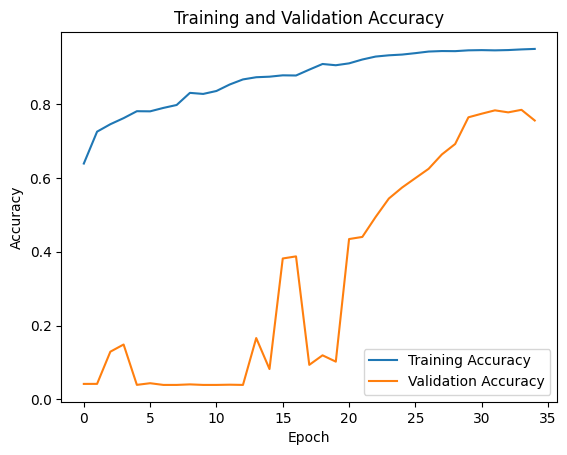

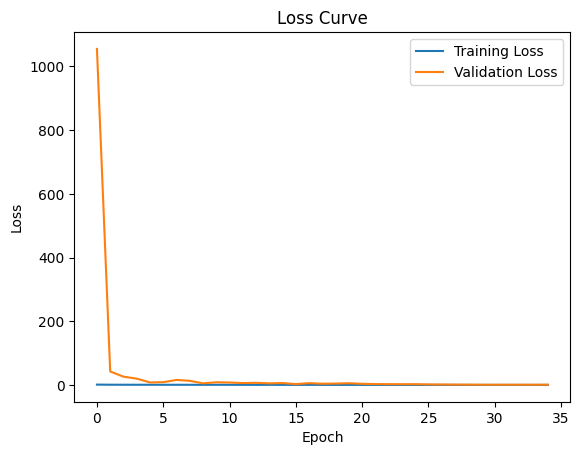

In [ ]:
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

Saving history to json file

In [ ]:
model.save('/content/drive/MyDrive/unet_resnet_50/deeplab_101_trial17.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#to load a pre-trained model and run
import random
model = tf.keras.models.load_model(r'/content/drive/MyDrive/unet_resnet_50/deeplab_101_trial17.h5')

rand_val = random.randint(1,392)
# 190 , 263 , 354
#original image
input_img = cv2.imread(f'{dataset_path}/images/image_190.tif',1)
mask_img = cv2.imread(f'{dataset_path}/masks/mask_190.tif',1)
# input_img has shape (height, width, bands)

# Reshape the 3D image into a 2D array where each row is a pixel and each column is a band
pixels_img = input_img.reshape(-1, img.shape[-1])

# Initialize an empty array to store the scaled pixel values
scaled_pixels_img = np.empty_like(pixels_img, dtype=float)

# Apply Min-Max scaling to each band separately
for band in range(img.shape[-1]):
    scaler = MinMaxScaler()
    scaled_band = scaler.fit_transform(pixels_img[:, band].reshape(-1, 1))
    scaled_pixels_img[:, band] = scaled_band.flatten()

# Reshape the scaled pixels_img back to the original image shape
scaled_image = scaled_pixels_img.reshape(img.shape)

normalised_image = scaled_image

reshaped_img = np.expand_dims(normalised_image, axis=0)
predictions = model.predict(reshaped_img)

In [ ]:
categorical_mask = np.argmax(predictions[0], axis=2)
output_image = np.zeros((256, 256, 3), dtype=np.uint8)
# Map categorical labels to colors and fill the output image
for label, color in class_colors.items():
    output_image[categorical_mask == label] = color

Text(0.5, 1.0, 'Predicted Mask')

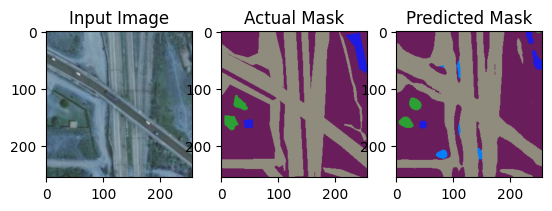

In [ ]:
plt.subplot(131)
plt.imshow(input_img)
plt.title("Input Image")

plt.subplot(132)
plt.imshow(mask_img)
plt.title("Actual Mask")

plt.subplot(133)
plt.imshow(output_image)
plt.title("Predicted Mask")

In [ ]:
import os
import cv2
import numpy as np

# Define a function to load and preprocess image and mask pairs
def load_images_and_masks(image_folder, mask_folder, image_size=(256, 256), num_samples=392, num_classes=6):
    images = []
    masks = []

    for i in range(1, num_samples + 1):
        image_path = os.path.join(image_folder, f"image_{i}.tif")
        mask_path = os.path.join(mask_folder, f"mask_{i}.tif")

        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)

        # Load and preprocess mask
        mask = cv2.imread(mask_path)

        # Check if either image or mask is invalid, and skip both
        if image is None or mask is None or mask.shape[0] != image_size[0] or mask.shape[1] != image_size[1]:
            print(f"Warning: Skipping image_{i}.tif and mask_{i}.tif due to invalid image or mask.")
            continue

        # Convert multiclass color mask to one-hot encoded mask
        mask_one_hot = np.zeros((image_size[0], image_size[1], num_classes), dtype=np.uint8)
        for class_id in range(num_classes):
            class_color = np.array([class_id, class_id, class_id])  # Assuming each class has a unique grayscale color
            mask_class = np.all(mask == class_color, axis=-1)
            mask_one_hot[:, :, class_id] = mask_class.astype(np.uint8)

        images.append(image)
        masks.append(mask_one_hot)

    return np.array(images), np.array(masks)


In [ ]:
image_path = os.path.join(image_folder, "image_1.tif")
mask_path = os.path.join(mask_folder, "mask_1.tif")

image = cv2.imread(image_path)
mask = cv2.imread(mask_path)

# Check if image and mask loaded successfully
if image is None or mask is None:
    print("Failed to load image or mask.")
else:
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)

In [ ]:
for i in range(1, 392 + 1):
    image_path = os.path.join(image_folder, f"image_{i}.tif")
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image {image_path}")
    else:
        print(f"Image {i} shape:", image.shape)

In [ ]:
for i in range(1, 392 + 1):
    if i == 376:
      continue
    mask_path = os.path.join(mask_folder, f"mask_{i}.tif")
    mask = cv2.imread(mask_path)

    if image is None:
        print(f"Failed to load mask {mask_path}")
    else:
        print(f"mask {i} shape:", mask.shape)